In [2]:
import numpy as np
import sys  
import matplotlib.pyplot as plt
import pickle
import gymnasium
import mountain_lite
fd = open('trajectories.pickle','rb')
D = pickle.load(fd)



In [3]:
env = gymnasium.make('mountain_lite/GridWorld-v0')

# task 1:


In [12]:
def mc_prediction_v(D, gamma=0.9):
    """
    Estimate the state-value function v_pi(s) using Monte Carlo evaluation.

    Parameters:
    - D: Trajectories, a list of episodes
    - gamma: Discount factor

    Returns:
    - V: The estimated state-value function
    """
    V = np.zeros((31, 100))  # Initialize state-value function
    returns = {}  # Dictionary to store returns for each state

    # Initialize returns
    for i in range(31):
        for j in range(100):
            returns[(i, j)] = []

    # Loop over trajectories
    for trajectory in D:
        G = 0  # Initialize return
        for step in reversed(trajectory):
            state, _, reward, _ = step
            G = reward + gamma * G
            if state not in [x[0] for x in trajectory[:trajectory.index(step)]]:
                returns[state].append(G)

    # Calculate average return for each state
    for state, Gs in returns.items():
        if Gs:  # Avoid division by zero
            V[state] = np.mean(Gs)

    return V


In [13]:
V = mc_prediction_v(D)

# task 2:

In [14]:
def mc_prediction_q(D, gamma=0.9):
    """
    Estimate the action-value function q_pi(a, s) using Monte Carlo evaluation.

    Parameters:
    - D: Trajectories, a list of episodes
    - gamma: Discount factor

    Returns:
    - Q: The estimated action-value function
    """
    Q = np.zeros((31, 100, 8))  # Initialize action-value function
    returns = {}  # Dictionary to store returns for each state-action pair

    # Initialize returns
    for i in range(31):
        for j in range(100):
            for a in range(8):
                returns[(i, j, a)] = []

    # Loop over trajectories
    for trajectory in D:
        G = 0  # Initialize return
        for step in reversed(trajectory):
            state, action, reward, _ = step
            G = reward + gamma * G
            if (state, action) not in [(x[0], x[1]) for x in trajectory[:trajectory.index(step)]]:
                returns[(state + (action,))].append(G)

    # Calculate average return for each state-action pair
    for state_action, Gs in returns.items():
        if Gs:  # Avoid division by zero
            Q[state_action] = np.mean(Gs)

    return Q


In [15]:
Q = mc_prediction_q(D)

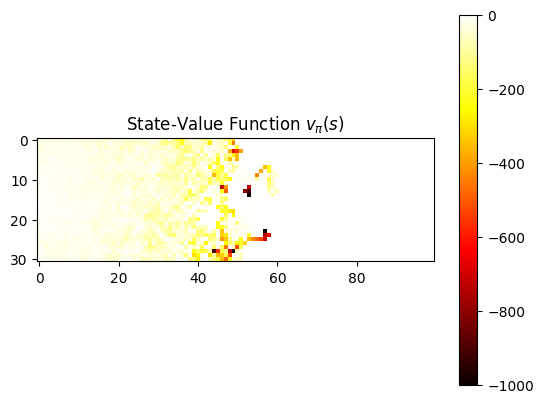

In [16]:
def plot_v(V):
    """
    Plot the state-value function v_pi(s).

    Parameters:
    - V: State-value function

    """
    plt.imshow(V, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('State-Value Function $v_π(s)$')
    plt.show()
plot_v(V)

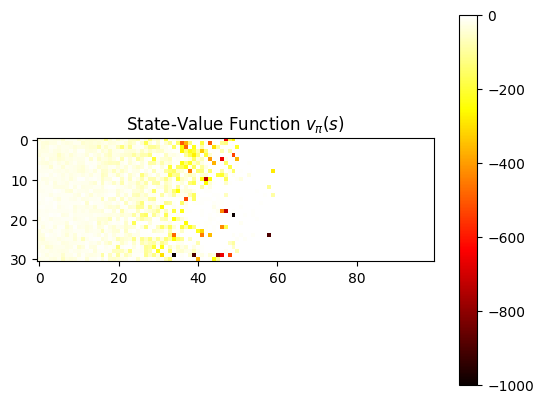

In [17]:
plot_v(Q[:,:,0])

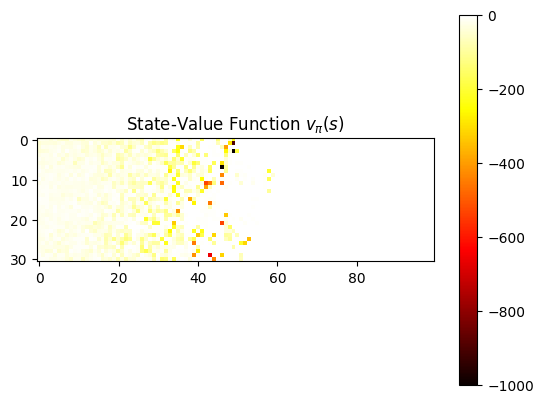

In [18]:
plot_v(Q[:,:,1])

# Task 5:

In [19]:
def mc_improvement(Q, epsilon=0.1):
    """
    Derive an improved policy from the action-value function Q using an epsilon-greedy approach.

    Parameters:
    - Q: The estimated action-value function, a numpy array of shape (num_states, num_actions)
    - epsilon: The probability of choosing a random action (exploration). 1 - epsilon is the probability of choosing the current best action (exploitation).

    Returns:
    - policy: The improved policy, a numpy array of shape (num_states,) indicating the best action for each state
    """
    policy = np.zeros((31, 100), dtype=int)  # Initialize policy with zeros

    for i in range(31):  # Loop over all states
        for j in range(100):
            if np.random.rand() < epsilon:  # With probability epsilon, choose a random action
                policy[i, j] = np.random.choice(8)
            else:  # With probability 1 - epsilon, choose the best action based on Q
                best_action = np.argmax(Q[i, j, :])
                policy[i, j] = best_action

    return policy


# technically task 5 and 6:

In [34]:
# MC Prediction Function for a single trajectory
def mc_prediction_q(trajectory, policy, gamma=0.9):
    Q = {}
    returns = {}

    G = 0
    for step in reversed(trajectory):
        state, action, reward, _ = step
        G = gamma * G + reward
        # Check if we have not visited this state-action pair in this trajectory
        if not step in trajectory[:trajectory.index(step)]:
            if (state, action) not in returns:
                returns[(state, action)] = []
            returns[(state, action)].append(G)
            Q[(state, action)] = np.mean(returns[(state, action)])
    return Q

# MC Improvement Function
def mc_improvement(Q, state_space, epsilon=0.1):
    policy = {}
    for state in state_space:
        actions = {a: Q.get((state, a), float('-inf')) for a in range(8)}
        best_action = max(actions, key=actions.get)
        if np.random.rand() < epsilon:
            policy[state] = np.random.choice(range(8))
        else:
            policy[state] = best_action
    return policy

# MC Control Function
def mc_control(D, num_iterations=10, gamma=0.9, epsilon=0.1):
    # Initialize policy randomly for states encountered in D
    state_space = set([step[0] for trajectory in D for step in trajectory])
    policy = {state: np.random.choice(range(8)) for state in state_space}
    
    for i in range(num_iterations):
        print('i',i)
        Q = {}
        # Loop through each trajectory in D
        # for trajectory in D:
        #     # Update the Q-values based on the trajectory and current policy
        #     Q.update(mc_prediction_q(trajectory, policy, gamma))
        for j in range(len(D)):
            
            Q.update(mc_prediction_q(D[j], policy, gamma))
            
            # Improve the policy based on the new action-value function estimate
            policy = mc_improvement(Q, state_space, epsilon)
        
    return policy

# Assuming D is defined as your dataset of trajectories
optimal_policy = mc_control(D)


i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9


task 7-9

In [35]:
import numpy as np
import gymnasium as gym
env = gym.make('mountain_lite/GridWorld-v0')

# Initialize Q-values
Q = np.zeros((31, 100, 8))  # For 31 rows, 100 columns, and 8 actions
returns = {(i, j, a): [] for i in range(31) for j in range(100) for a in range(8)}

# Initialize policy randomly
policy = np.random.choice(8, size=(31, 100))  # Each element is an action from 0 to 7

epsilon = 0.1  # Exploration rate
gamma = 0.9  # Discount factor




NamespaceNotFound: Namespace mountain_lite not found. Have you installed the proper package for mountain_lite?

In [36]:
def generate_episode(env, policy, epsilon):
    episode = []
    state = env.reset()
    done = False
    while not done:
        if np.random.rand() < epsilon:
            action = np.random.choice(8)  # Explore: choose a random action
        else:
            action = policy[state]  # Exploit: choose the best action from policy
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def update_Q(episode):
    G = 0
    for state, action, reward in reversed(episode):
        G = gamma * G + reward
        if not any((s == state and a == action) for s, a, _ in episode[:-1]):
            returns[state + (action,)].append(G)
            Q[state + (action,)] = np.mean(returns[state + (action,)])


In [ ]:
def improve_policy():
    for i in range(31):
        for j in range(100):
            policy[i, j] = np.argmax(Q[i, j])
            





In [ ]:
def control():
    num_episodes = 10000  # Total number of episodes to run
    for _ in range(num_episodes):
        episode = generate_episode(env, policy, epsilon)
        update_Q(episode)
        improve_policy()
